<a href="https://colab.research.google.com/github/jproctor-rebecca/lambdaprojects/blob/master/Spotify_recommender_NN_explore_RJProctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and enviroment setup

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, BallTree
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# random state
rs = 42

## Load and clean data

In [2]:
# load data
# URL = 'https://github.com/Build-Week-Track-Team-7/explore/blob/main/data.csv.zip?raw=true'

# path_to_zip = tf.keras.utils.get_file('./data.zip', origin=URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

df_raw = pd.read_csv('./data.csv')
df_raw.head()


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"FantasiestÃ¼cke, Op. 111: PiÃ¹ tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn GoszczyÅ„ski'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,9/25/1928,0.0926,108.003,0.7200,1928
4,0.990,"['FrÃ©dÃ©ric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [3]:
    
def clean_data(df):
  '''
  a functions that drops columns which either 
  add bias or noise to dataset 

  raw text data
  ---
  input - dataframe object/ndarray
  output - dataframe object/ndarray
  '''
  # bias
  df_cleaned = df.drop('artists', axis=1)
    # duplicate/triplicate information may disproportantly weight results
  df_cleaned = df_cleaned.drop('release_date', axis=1)
    # duplicate/triplicate information may disproportantly weight results

  # noise
  df_cleaned = df_cleaned.drop('id', axis=1)
    # has no meaningful contribution to results

  # drop rows with missing values
  df_cleaned = df_cleaned.dropna()

  # cast column(s) to integer dtype
  # df_cleaned = df_cleaned.astype({'acousticness': 'int64',
  #                                 'danceability': 'int64',
  #                                 'energy': 'int64',
  #                                 'instrumentalness': 'int64',
  #                                 'liveness': 'int64',
  #                                 'liveness': 'int64',
  #                                 'loudness': 'int64',
  #                                 'speechiness': 'int64',
  #                                 'tempo': 'int64',
  #                                 'valence': 'int64'}).dtypes

  return df_cleaned


data_cleaned = clean_data(df_raw)
print(data_cleaned.shape)
data_cleaned.head()

(169909, 16)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year
0,0.995,0.708,158648,0.1950,0,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,0.0506,118.469,0.7790,1928
1,0.994,0.379,282133,0.0135,0,0.901,8,0.0763,-28.454,1,"FantasiestÃ¼cke, Op. 111: PiÃ¹ tosto lento",0,0.0462,83.972,0.0767,1928
2,0.604,0.749,104300,0.2200,0,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,0.9290,107.177,0.8800,1928
3,0.995,0.781,180760,0.1300,0,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,0.0926,108.003,0.7200,1928
4,0.990,0.210,687733,0.2040,0,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,0.0424,62.149,0.0693,1928


In [4]:
# shuffle dataset to avoid bias
num_rows = 169909
data_cleaned = data_cleaned.sample(n=num_rows, 
                                   replace=False,
                                   random_state=rs
                                   )

# reindex 
data_cleaned = data_cleaned.reset_index(drop=True)


In [5]:
data_cleaned.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year
0,0.103,0.799,181267,0.2740,0,0.000031,7,0.0961,-18.148,1,If Not Now...,48,0.0371,108.926,0.530,1988
1,0.977,0.648,241000,0.0391,0,0.000056,9,0.0917,-22.378,1,I've Got The World On A String,16,0.0372,76.184,0.327,1957
2,0.983,0.675,95973,0.3660,0,0.000000,7,0.8420,-7.469,1,Mamita Mia - Remastered,2,0.1100,96.558,0.667,1936
3,0.973,0.293,212480,0.1500,0,0.001090,8,0.1340,-12.880,0,"Puccini: Madama Butterfly, Act 2: ""Che tua mad...",13,0.0400,62.904,0.101,1955
4,0.765,0.560,613040,0.3800,0,0.710000,0,0.0638,-11.762,1,Maui-Waui,34,0.0346,80.698,0.389,1977


#### EDA

In [6]:
data_cleaned.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,169909.000000,169909.000000,1.699090e+05,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,0.493214,0.538150,2.314062e+05,0.488593,0.084863,0.161937,5.200519,0.206690,-11.370289,0.708556,31.556610,0.094058,116.948017,0.532095,1977.223231
std,0.376627,0.175346,1.213219e+05,0.267390,0.278679,0.309329,3.515257,0.176796,5.666765,0.454429,21.582614,0.149937,30.726937,0.262408,25.593168
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.094500,0.417000,1.710400e+05,0.263000,0.000000,0.000000,2.000000,0.098400,-14.470000,0.000000,12.000000,0.034900,93.516000,0.322000,1957.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000000,0.000204,5.000000,0.135000,-10.474000,1.000000,33.000000,0.045000,114.778000,0.544000,1978.000000
75%,0.888000,0.667000,2.629600e+05,0.710000,0.000000,0.086800,8.000000,0.263000,-7.118000,1.000000,48.000000,0.075400,135.712000,0.749000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.969000,244.091000,1.000000,2020.000000


In [7]:
data_cleaned.describe(exclude='number')

,name
count,169909
unique,132939
top,Summertime
freq,62


In [8]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   danceability      169909 non-null  float64
 2   duration_ms       169909 non-null  int64  
 3   energy            169909 non-null  float64
 4   explicit          169909 non-null  int64  
 5   instrumentalness  169909 non-null  float64
 6   key               169909 non-null  int64  
 7   liveness          169909 non-null  float64
 8   loudness          169909 non-null  float64
 9   mode              169909 non-null  int64  
 10  name              169909 non-null  object 
 11  popularity        169909 non-null  int64  
 12  speechiness       169909 non-null  float64
 13  tempo             169909 non-null  float64
 14  valence           169909 non-null  float64
 15  year              169909 non-null  int64  
dtypes: float64(9), int64

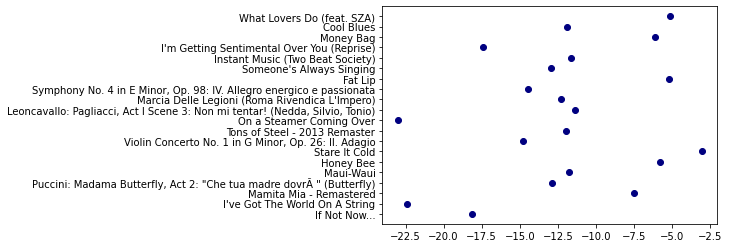

In [9]:
# scatter plot of features as they relate to sampling of individual songs
# features within the -25 to 0 range
plt.scatter(data_cleaned['loudness'][:20], data_cleaned['name'][:20], c='navy')
plt.show()


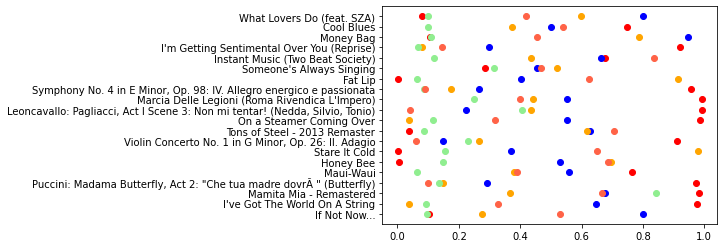

In [10]:
# features within the 0-1 range
plt.scatter(data_cleaned['acousticness'][:20], data_cleaned['name'][:20], c='red')
plt.scatter(data_cleaned['danceability'][:20], data_cleaned['name'][:20], c='blue')
plt.scatter(data_cleaned['energy'][:20], data_cleaned['name'][:20], c='orange')
plt.scatter(data_cleaned['liveness'][:20], data_cleaned['name'][:20], c='lightgreen')
plt.scatter(data_cleaned['valence'][:20], data_cleaned['name'][:20], c='tomato')

plt.show()

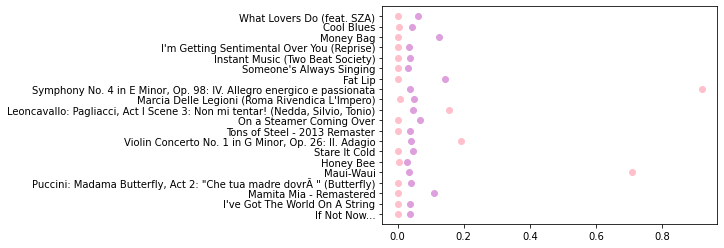

In [11]:
# features that may have some correlation
plt.scatter(data_cleaned['instrumentalness'][:20], data_cleaned['name'][:20], c='pink')
plt.scatter(data_cleaned['speechiness'][:20], data_cleaned['name'][:20], c='plum')
plt.show()

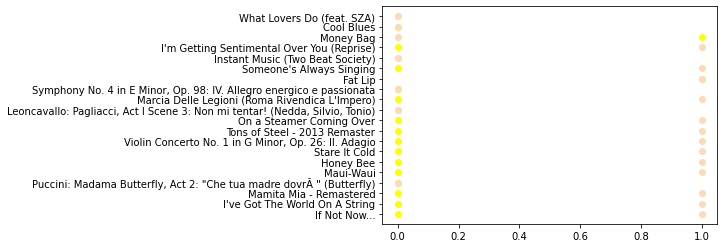

In [12]:
# boolean values
plt.scatter(data_cleaned['explicit'][:20], data_cleaned['name'][:20], c='yellow')
plt.scatter(data_cleaned['mode'][:20], data_cleaned['name'][:20], c='peachpuff')
plt.show()

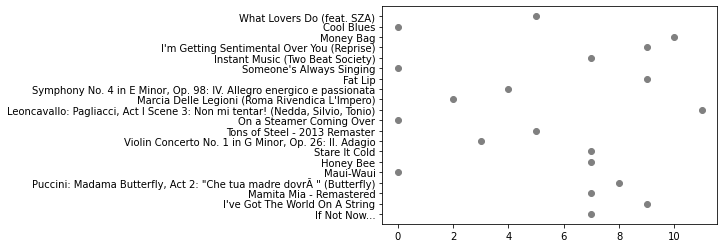

In [13]:
# features within the 1 - 11 range
plt.scatter(data_cleaned['key'][:20], data_cleaned['name'][:20], c='gray')
plt.show()

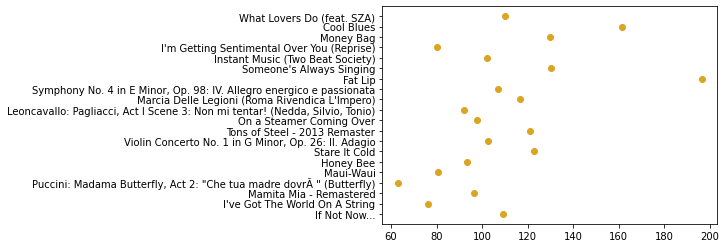

In [14]:
# features within the 70 - 170 range
plt.scatter(data_cleaned['tempo'][:20], data_cleaned['name'][:20], c='goldenrod')
plt.show()

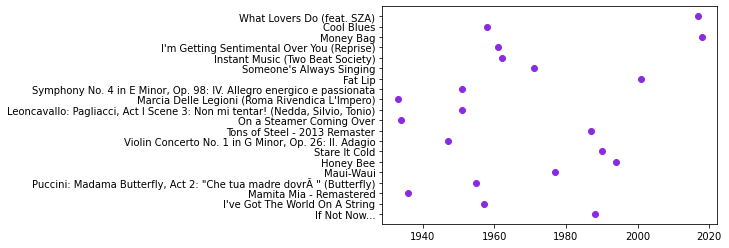

In [15]:
# features within years 1921 - 2020 
plt.scatter(data_cleaned['year'][:20], data_cleaned['name'][:20], c='blueviolet')
plt.show()

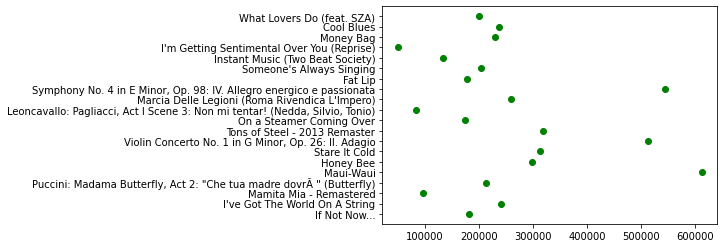

In [16]:
# features within the 200000 - 800000 range
plt.scatter(data_cleaned['duration_ms'][:20], data_cleaned['name'][:20], c='green')
plt.show()

## Additional preproccessing of data
Pipeline 1 - (instantiate, fit_transform)


*   StandardScaler

Pipeline 2a, 2b, 2c, and 2d - (instantiate, fit, predict)

2a:
*   K-NN - (exploring in isolation for similiarity clustering efficienies)

2b:

*   K-NN - (exploring for similiarity clustering efficienies)
*   PCA - (exploring for efficiency boost not dimensionality reduction b/c this is not needed; already done by limiting features)


2c:
*   K-NN - (exploring for similiarity clustering efficienies)
*   t_SNE - (exploring for additional efficiencies in dimensionality reduction)

2d:
*   t_SNE - (exploring in isolation for efficiencies in dimensionality reduction)


#### Pipeline 1
*   StandardScaler

In [17]:
# create feature matrix
X = data_cleaned.drop('name', axis=1)
y = data_cleaned['name']



In [18]:
# normalize standardize data using pipeline (instantiate, fit, transform)
# onehotender, ordinal encoder, standard scaler in order

# instantiate pipeline
pipe_1 = Pipeline([
                 #('onehotencoder', OneHotEncoder()), 
                 #('ordinalencoder', OrdinalEncoder()), 
                 ('scaler', StandardScaler()), 
                 ])

# fit data to transformer and transform data
pipe_1.fit_transform(X, y=None)


#  check data
print(X.shape)
print(y.shape)


(169909, 15)
(169909,)


In [19]:
# split data - train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42
                                                    )

# X_arr = np.asarray(X)
# y_arr = np.asarray(y)


# # split data - train/test split
# X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, 
#                                                     test_size=0.20, 
#                                                     random_state=42
#                                                     )

# check data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(135927, 15)
(135927,)
(33982, 15)
(33982,)


#### Pipeline *2a*
2a:

K-NN - (exploring in isolation for similiarity clustering efficienies)

In [20]:
# hyperparameters for piplines
# K-NN estimator
n_neigh = 25
  # must be an interger or will throw an error
alg = 'ball_tree'

#TFIDF Vectorizer
max_df=5
max_fea=10000
min_df=1
st_wds='english'
use_idf=True

# SVD
n_comp=14
  # must be an integer
_alg='arpack'
  # as an eigensolver for greater efficiency while maintaining accuracy when interacing with Spotify API
  # can switch to 'randomized' for greater efficiency if needed

# KMeans
n_clus=10
init='k-means++'
max_iter=100
n_init=1
verbose=2




In [21]:
# instantiate model
nbrs = NearestNeighbors(n_neighbors=n_neigh, 
                 algorithm=alg)

# fit data
nbrs = nbrs.fit(X_train)


# check data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(135927, 15)
(135927,)
(33982, 15)
(33982,)


In [22]:
#dir(nbrs)

#### Pipeline *2b*
2b:

Tfidf - (vectorizer)

t-SVD - (exploring for efficiency boost not dimensionality reduction b/c this is not needed; already done by limiting features)

KMeans - (exploring similarities through clustering)

In [23]:
# instantiate pipeline
pipe_2b = Pipeline([
                 ('tfidf', TfidfVectorizer(max_df=max_df, 
                                           max_features=max_fea,
                                           min_df=min_df,
                                           stop_words=st_wds,
                                           use_idf=True)
                 ),
                 ('svd', TruncatedSVD(n_components=n_comp,
                             algorithm=_alg)
                 ),
                 ('km', KMeans(n_clusters=n_clus,
                                   init=init,
                                   max_iter=max_iter,
                                   n_init=n_init,
                                   verbose=verbose)
                 ), 
                 ])

# fit data to transformer and transform data
km = pipe_2b.fit(X_train)


# check data
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4.304761415934
start iteration
done sorting
end inner loop
Iteration 1, inertia 4.304761415934
center shift 0.000000e+00 within tolerance 6.199908e-06

(135927, 15)
(135927,)
(33982, 15)
(33982,)


#### Pipeline *2c*
2c:

K-NN - (exploring for similiarity clustering efficienies)

t_SNE - (exploring for additional efficiencies in dimensionality reduction)

#### Pipeline *2d*
2d:

t_SNE - (exploring for additional efficiencies in dimensionality reduction)

## Neural Network model(s) 
NN 1 - (instantiate, compile, fit)
*   CNN

> Indented block



NN 2 - (instantiate, compile, fit)
*   LSTM

NN 3 - (instantiate, compile, fit)
*   RNN (deep and wide)

#### NN 1 - (instantiate, compile, fit)

CNN

In [26]:
# define and tune hyperparameters within NN
# CNN
batch_size = 32
epochs = 5


# LSTM layer(s)
units_lstm = len(np.unique(y_train)) * .75
units_lstm = units_lstm.is_integer()
do = 0.2

# Embedding layer
max_feat = 10000
units_em = len(np.unique(y_train)) * .75
units_em = units_em.is_integer()

# Dense hidden layer(s)
act_hid = 'relu'

# Dense output layer
units_out = len(np.unique(y_train))
act_out = 'softmax'
  # for use with multiclass

# general use
maxlen = 80
shape = X_train.shape[1]

# compile and fit
loss='sparse_categorical_crossentropy'
batch_sz = 32
opt = 'nadam'
metric='accuracy'

X_train = np.array([np.expand_dims(x_, 1) for x_ in X_train.values])
X_test = np.array([np.expand_dims(x_, 1) for x_ in X_test.values])

In [23]:
# check data
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# of lables in output layer
len(np.unique(y_train))

In [ ]:
# Setup Architecture

# instantiate model
model = Sequential()

# -- preprocessing portion of CNN network --

# hidden pre-processing layer 1 with implicit input layer
# creates feature map
# activation function used to produce updated weights (allows backpropegation)
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32, 15)))

# hidden preprocessing layer 2
# subsample values
model.add(MaxPooling2D((2,2)))

# hidden preprocessing layer 3
# creates feature map
# activation function used to produce updated weights (allows backpropegation)
model.add(Conv2D(64, (3,3), activation='relu'))

# hidden preprocessing layer 4
# subsample values
model.add(MaxPooling2D((2,2)))

# hidden preporocessing layer 5
# creates feature map
# activation function used to produce updated weights (allows backpropegation)
model.add(Conv2D(64, (3,3), activation='relu'))

# hidden preporcessing layer 6
# standardiztion/normalization 
model.add(GlobalAveragePooling2D())
  # a Fancy version of Flatten with subsample values

# -- fully connected portion of CNN network --

# hidden layer 7
model.add(Dense(64, activation='relu'))

# output layer 8
model.add(Dense(10, activation='softmax'))

model.summary()

In [ ]:
# Compile Model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
results = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

#### NN 2 - (instantiate, compile, fit)

LSTM

In [ ]:
# check data
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [25]:
# of lables in output layer
len(np.unique(y_train))

109700

In [ ]:
## TODO...tokenize lemmas

In [ ]:
# instantiating a Sequential class 
model = Sequential()

# explicit input layer  
#model.add(Embedding(max_feat, units_em))

# hidden layer 1 
model.add(LSTM(units=units_lstm, dropout=do, return_sequences=True, input_shape=shape))

# hidden layer 2
#model.add(LSTM(units=units_lstm, dropout=do, return_sequences=True))

# hidden layer 3 
#model.add(LSTM(units=units_lstm, dropout=do))

# hidden layer 4
#model.add(Dense(units=units_out, activation=act_hid))

# output layer 
model.add(Dense(units_out, activation=act_out))

model.compile(loss=loss,
              optimizer=opt, 
              metrics=[metric])

# fit model
results = model.fit(X_train, y_train,
          batch_size=32, 
          epochs=5,
          steps_per_epoch=1000, 
          validation_data=(X_test, y_test)
)

# display model
model.summary()

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(results_nn2.history['loss'])
plt.plot(results_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(results_nn2.history['accuracy'])
plt.plot(results_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

#### NN 3 - (instantiate, compile, fit)

RNN (deep and wide)

## Evaluate model

## Vizualize results

## Conclusions

## Export to application

In [ ]:
# convert to json
